# Spatial Flux Decomposition

Just does the decomposition over each grid cell instead of the area-weighted average.

In [36]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('seaborn-whitegrid')
import seaborn as sns
from esmtools.physics import stress_to_speed
#from esmtools.carbon import schmidt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import esmtools as et
import glob

In [37]:
"""
Some constants that are pertinent for this.
"""
a = 6.972e-7 # Flux coefficient in s/m
conversion = (60 * 60 * 24 * 365) / 1e3 # Applied to every term of the expansion to have proper units (see notes)
S0 = 35 # Salinity constant

In [38]:
e = 'HumCS'
x = 'NINO3'
smooth = 0

Load ensemble means to compute sensitivities

In [39]:
def load_ensemble_mean(e, v):
    """
    Loads in the ensemble mean time series for a given upwelling system (e)
    and variable (v). I will use these to compute the sensitivities, which shouldn't
    cause too much error since it's a much larger value than the residuals.
    """
    filepath = ('/glade/work/rbrady/EBUS_BGC_Variability/' + v + '/' + e +
               '/filtered_output/' + e.lower() + '-' + v + '-forced-signal-chavez-800km.nc')
    da = xr.open_dataarray(filepath)
    da.name = v
    return da

In [40]:
variables = ['FG_CO2', 'SST', 'SALT', 'DIC', 'ALK', 'TAUX',
             'TAUY', 'TAUX2', 'TAUY2', 'sDIC', 'sALK', 'U',
             'DCO2STAR', 'RHO', 'pCO2SURF']
forced = xr.Dataset()
for i, name in enumerate(variables):
    da = load_ensemble_mean(e, name)
    forced = xr.merge([forced, da])

In [41]:
forced = forced.rename({'pCO2SURF': 'pCO2'})
means = forced.mean('time')

Load in regressions

In [74]:
def load_regression(e, x, y, smooth):
    """
    Loads in the area-weighted regression results for a given upwelling system
    (e), predictor variable (x), and dependent variable (y). Need to add functionality
    for lagging. Currently assumes values of 0 for each of those features.
    """
    filepath = ('/glade/work/rbrady/EBUS_BGC_Variability/regional_regressions/' +
                e + '/' + y + '/' + x + '/lag0/')
    ds = xr.open_mfdataset(filepath + '*.nc', concat_dim='ensemble')
#    if smooth == 0:
        #filename = (x + '.' + y + '.' + e + '.unsmoothed.area_weighted_regional_regression.lag0.nc')
#        pass
#    else:
#        filename = (x + '.' + y + '.' + e + '.smoothed' + str(smooth) + '.regional_regression.lag0.nc')
#   ds = xr.open_mfdataset(filepath + filename)
    return ds

In [75]:
delta_FG_CO2 = load_regression(e, x, 'FG_CO2', smooth)
delta_U = load_regression(e, x, 'U', smooth)
delta_SST = load_regression(e, x, 'SST', smooth)
delta_SALT = load_regression(e, x, 'SALT', smooth)
delta_sDIC = load_regression(e, x, 'sDIC', smooth)
delta_sALK = load_regression(e, x, 'sALK', smooth)

In [82]:
"""
tolerance = 0.1
np.where((delta_FG_CO2['p'] <= tolerance) & 
         (delta_U['p'] <= tolerance) &
         (delta_SST['p'] <= tolerance) &
         (delta_SALT['p'] <= tolerance) &
         (delta_sDIC['p'] <= tolerance) &
         (delta_sALK['p'] <= tolerance))
"""
# Seems impossible to get all 34 members to be significant in all terms. So maybe just
# test significance of FG_CO2?
tolerance = 0.1
delta_U = delta_U.where(delta_FG_CO2['p'] <= tolerance, drop=True)
delta_SST = delta_SST.where(delta_FG_CO2['p'] <= tolerance, drop=True)
delta_SALT = delta_SALT.where(delta_FG_CO2['p'] <= tolerance, drop=True)
delta_sDIC = delta_sDIC.where(delta_FG_CO2['p'] <= tolerance, drop=True)
delta_sALK = delta_sALK.where(delta_FG_CO2['p'] <= tolerance, drop=True)
delta_FG_CO2 = delta_FG_CO2.where(delta_FG_CO2['p'] <= tolerance, drop=True)
N = len(delta_FG_CO2['m'])

/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2

## Compute terms

In [86]:
def co2_sol(ds):
    """
    NOTE: This is from my esmtools co2_sol script. Just editing it here to make it usable
    over a grid.
    
    Compute CO2 sollubility per the equation used in CESM. The mean will be taken over
    the time series provided to produce the average solubility over this time period.
    Thus, if you want more accurate solubility you can feed in smaller time periods.
    Input
    -----
    t : SST time series (degC) 
    s : SSS time series (PSU)
    Return
    ------
    ff : Value of solubility in mol/kg/atm
    References
    ----------
    Weiss & Price (1980, Mar. Chem., 8, 347-359;
    Eq 13 with table 6 values)
    """
    a = [-162.8301, 218.2968, 90.9241, -1.47696]
    b = [0.025695, -0.025225, 0.0049867]
    t = (ds['SST'].mean('time') + 273.15) * 0.01
    s = ds['SALT'].mean('time')
    t_sq = t**2
    t_inv = 1.0 / t
    log_t = np.log(t)
    d0 = b[2] * t_sq + b[1] * t + b[0]
    # Compute solubility in mol.kg^{-1}.atm^{-1}
    ff = np.exp( a[0] + a[1] * t_inv + a[2] * log_t + \
        a[3] * t_sq + d0 * s )
    return ff

In [87]:
def schmidt(t):
    """
    Vectorized version of schmidt script from esmtools. Just input a time-mean
    of the grid.
    """
    c = [2073.1, 125.62, 3.6276, 0.043219]
    Sc = c[0] - c[1]*t + c[2]*(t**2) - c[3]*(t**3)
    return Sc

In [88]:
"""
Repetitive terms
"""
Sc = schmidt(forced['SST'].mean('time'))
sol_grid = xr.merge([forced['SST'], forced['SALT']])
ff = co2_sol(sol_grid)
gamma_DIC = (3*means['ALK']*means['DIC'] - 2*means['DIC']**2) / \
            ((2*means['DIC']-means['ALK'])*(means['ALK']-means['DIC']))
gamma_ALK = (-means['ALK']**2)/((2*means['DIC']-means['ALK'])*(means['ALK']-means['DIC']))

""" 
The conversion term converts to the proper mol/m2/yr for every unit. So that we actually have each term
summing to a mol/m2/yr perturbation from some climate event.

Can run a np.where command on the original delta datasets to drop non-significant results.
"""
# SENSITIVITIES
dFdpCO2 = means['RHO']*ff*a*np.sqrt(660/Sc)*means['U']**2
dFdU = -2*a*np.sqrt(660/Sc)*means['U']*means['DCO2STAR']
dFdSST = dFdpCO2*0.0423*means['pCO2']
dFdSALT = dFdpCO2*(means['pCO2']/means['SALT'])
dpCO2dDIC = (means['pCO2']*gamma_DIC)/means['DIC']
dpCO2dALK = (means['pCO2']*gamma_ALK)/means['ALK']

# FULL TERM
F = delta_FG_CO2['m']
U = dFdU*delta_U['m']*conversion
SST = dFdSST*delta_SST['m']*conversion
SALT = dFdSALT*delta_SALT['m']*conversion
sDIC = dFdpCO2*dpCO2dDIC*(means['SALT']/S0)*delta_sDIC['m']*conversion
sALK = dFdpCO2*dpCO2dALK*(means['SALT']/S0)*delta_sALK['m']*conversion

# Freshwater
term1 = dFdpCO2*dpCO2dDIC*(means['sDIC']/S0)*delta_SALT['m']*conversion
term2 = dFdpCO2*dpCO2dALK*(means['sALK']/S0)*delta_SALT['m']*conversion
FW = term1 + term2

In [89]:
# Summed maps
taylor_sum = U + SST + SALT + sDIC + sALK
true_sum = F
diff = abs(taylor_sum) - abs(true_sum)

# Plotting and Analysis

### Spatial maps for each term.

In [90]:
def plot_term(ax, term, title):
    lon = term.TLONG
    lat = term.TLAT
    x0,x1,y0,y1 = et.ebus.visual_bounds(e)
    p = ax.pcolor(lon-1, lat, term.mean('ensemble'), transform=ccrs.PlateCarree(),
                cmap="RdBu_r", vmin=-0.4, vmax=0.4, edgecolor='w')
    ax.set_extent([x0,x1,y0,y1])
    ax.add_feature(cfeature.LAND, facecolor='k')
    ax.outline_patch.set_edgecolor('white')
    ax.set_title(title)
    return p

/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


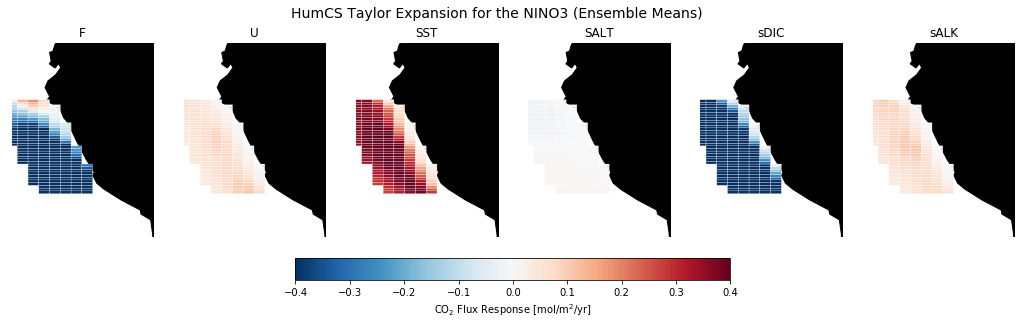

In [97]:
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(18,8), subplot_kw=dict(projection=ccrs.Mercator()))

# Plot Terms 
terms = [F, U, SST, SALT, sDIC, sALK]
titles = ['F', 'U', 'SST', 'SALT', 'sDIC', 'sALK']
for i, name in enumerate(terms):
    p = plot_term(ax[i], name, titles[i])

cb = f.colorbar(p, ax=ax.ravel().tolist(), orientation='horizontal',
             fraction=0.05, pad=0.05, ticks=[-0.4,-0.3,-0.2, -0.1, 0, 0.1, 0.2,0.3,0.4])
cb.set_label('CO$_{2}$ Flux Response [mol/m$^{2}$/yr]')

f.suptitle(e + " Taylor Expansion for the " + x + " (Ensemble Means)", fontsize=14, y=0.6)

#et.vis.savefig(e + '_' + x + '_' + 'spatial_taylor_expansion_means', extension='.eps', dpi=300)

Ensemble Spread

In [98]:
def plot_term(ax, term, title):
    lon = term.TLONG
    lat = term.TLAT
    x0,x1,y0,y1 = et.ebus.visual_bounds(e)
    p = ax.pcolor(lon-1, lat, term.std('ensemble'), transform=ccrs.PlateCarree(),
                cmap="Purples", vmin=0, vmax=0.1, edgecolor='w')
    ax.set_extent([x0,x1,y0,y1])
    ax.add_feature(cfeature.LAND, facecolor='k')
    ax.outline_patch.set_edgecolor('white')
    ax.set_title(title)
    return p

/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


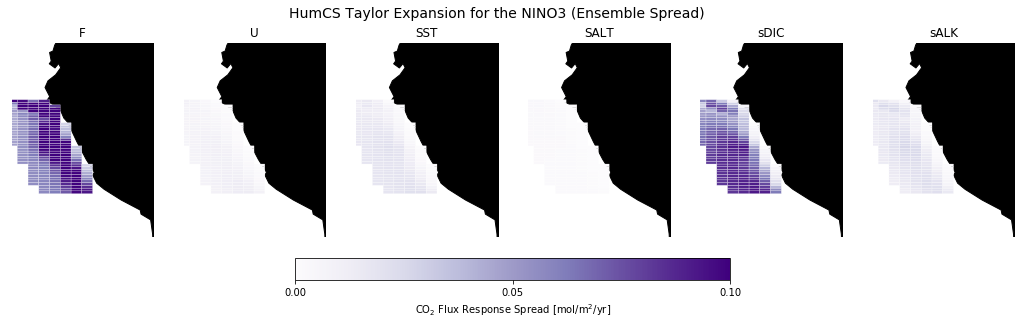

In [100]:

f, ax = plt.subplots(nrows=1, ncols=6, figsize=(18,8), subplot_kw=dict(projection=ccrs.Mercator()))

# Plot Terms 
terms = [F, U, SST, SALT, sDIC, sALK]
titles = ['F', 'U', 'SST', 'SALT', 'sDIC', 'sALK']
for i, name in enumerate(terms):
    p = plot_term(ax[i], name, titles[i])

cb = f.colorbar(p, ax=ax.ravel().tolist(), orientation='horizontal',
             fraction=0.05, pad=0.05, ticks=[0, 0.05, 0.1])
cb.set_label('CO$_{2}$ Flux Response Spread [mol/m$^{2}$/yr]')

f.suptitle(e + " Taylor Expansion for the " + x + " (Ensemble Spread)", fontsize=14, y=0.6)

#et.vis.savefig(e + '_' + x + '_spatial_taylor_expansion_spread', extension='.eps', dpi=300)

### Approx. versus direct regression

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(13,4), subplot_kw=dict(projection=ccrs.Mercator()))
lon = taylor_sum.TLONG
lat = taylor_sum.TLAT

# Approx Sum
x0,x1,y0,y1 = et.ebus.visual_bounds('CalCS')
p = ax[0].pcolor(lon-1, lat, taylor_sum.mean('ensemble'), transform=ccrs.PlateCarree(),
                cmap="RdBu_r", vmin=-0.1, vmax=0.1, edgecolor='w')
ax[0].set_extent([x0,x1,y0,y1])
ax[0].add_feature(cfeature.LAND, facecolor='k')
ax[0].outline_patch.set_edgecolor('white')
ax[0].set_title('Taylor Approximation')

# "True" Sum
x0,x1,y0,y1 = et.ebus.visual_bounds('CalCS')
ax[1].pcolor(lon-1, lat, true_sum.mean('ensemble'), transform=ccrs.PlateCarree(),
                cmap="RdBu_r", vmin=-0.1, vmax=0.1, edgecolor='w')
ax[1].set_extent([x0,x1,y0,y1])
ax[1].add_feature(cfeature.LAND, facecolor='k')
ax[1].outline_patch.set_edgecolor('white')
ax[1].set_title('Direct Regression')

# Difference
x0,x1,y0,y1 = et.ebus.visual_bounds('CalCS')
p2 = ax[2].pcolor(lon-1, lat, diff.mean('ensemble'), transform=ccrs.PlateCarree(),
                cmap="BrBG_r", vmin=-0.1, vmax=0.1, edgecolor='w')
ax[2].set_extent([x0,x1,y0,y1])
ax[2].add_feature(cfeature.LAND, facecolor='k')
ax[2].outline_patch.set_edgecolor('white')
ax[2].set_title('Difference (Approx - Direct)')

f.suptitle("CalCS Taylor Expansion for the NPGO", fontsize=14)
#f.tight_layout()
cb = f.colorbar(p, ax=ax.ravel().tolist(), orientation='horizontal',
             fraction=0.05, pad=0.05, ticks=[-0.1, -0.05, 0, 0.05, 0.1])
cb.set_label('CO$_{2}$ Flux Response [mol/m$^{2}$/yr]')
cb2 = f.colorbar(p2, ax = ax[2], orientation='horizontal',
                fraction=0.05, pad=0.05, ticks=[-0.1, -0.05, 0, 0.05, 0.1])
cb2.set_label('Difference [mol/m$^{2}$/yr]')

#############

#et.vis.savefig('CalCS_spatial_decomp_NPGO', extension='.eps', dpi=300)
